In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

In [27]:
from pyomo.environ import *

# Input Data: Meal names and their nutritional values (Calories, Protein (g), Carbs (g), Fats (g), Cost)
breakfast_meals = ['Oatmeal with fruit', 'Eggs and toast', 'Yogurt with granola', 'Smoothie (Banana, Spinach, Protein)', 'Avocado toast with egg',
                   'Pancakes', 'Granola with milk']  # Added two new options for variety

lunch_and_dinner_meals = ['Chicken Bowl', 'Pizza', 'Spaghetti', 'Soup', 'Black Bean Bowl', 'Grilled Salmon', 'Veggie Stir Fry',
                          'Taco Bowl', 'Cauliflower Rice Bowl', 'Quinoa Salad', 'Grilled Chicken Salad', 'Veggie Burger']  # Added two new options

# Breakfast meal nutritional values (Calories, Protein (g), Carbs (g), Fats (g), Cost)
breakfast_nutrition_and_cost = [
    [300, 5, 50, 8, 2],    # Oatmeal with fruit
    [350, 20, 30, 15, 3],  # Eggs and toast
    [250, 15, 40, 8, 2.5], # Yogurt with granola
    [400, 25, 50, 10, 4],  # Smoothie (Banana, Spinach, Protein)
    [500, 20, 40, 25, 5],  # Avocado toast with egg
    [450, 10, 70, 10, 3],  # Pancakes (new)
    [350, 8, 60, 7, 2.8]   # Granola with milk (new)
]

# Lunch/Dinner meal nutritional values (Calories, Protein (g), Carbs (g), Fats (g), Cost)
meal_nutrition_and_cost = [
    [600, 40, 50, 20, 5],    # Chicken Bowl
    [800, 30, 90, 30, 7],    # Pizza
    [700, 25, 90, 15, 6],    # Spaghetti
    [400, 20, 40, 10, 4],    # Soup
    [550, 25, 80, 15, 5],    # Black Bean Bowl
    [500, 35, 5, 25, 8],     # Grilled Salmon
    [450, 15, 60, 10, 6],    # Veggie Stir Fry
    [700, 30, 80, 25, 7],    # Taco Bowl
    [450, 25, 40, 10, 5],    # Cauliflower Rice Bowl
    [350, 10, 50, 5, 4],     # Quinoa Salad
    [500, 30, 40, 15, 6],    # Grilled Chicken Salad (new)
    [550, 25, 50, 20, 6.5]   # Veggie Burger (new)
]

# Input Data: Fruits, their nutritional values and costs
fruits = ['Apple', 'Banana', 'Orange', 'Grapes', 'Pineapple', 'Mango', 'Strawberry']
fruit_nutrition_and_cost = [
    [95, 0, 25, 0, 1],    # Apple
    [105, 1, 27, 0, 1],   # Banana
    [62, 1, 15, 0, 1],    # Orange
    [104, 1, 27, 0, 1],   # Grapes
    [82, 1, 22, 0, 1],    # Pineapple
    [150, 1, 38, 0, 2],   # Mango
    [50, 1, 12, 0, 1]     # Strawberry
]

# Nutritional daily requirements (calories, protein, carbs, fats)
required_calories = 2000
required_protein = 100
required_carbs = 250
required_fats = 70

# Create a Pyomo model
model = ConcreteModel()

# Decision variables: Meal selection for each day, for each meal, and for fruits
model.x1 = Var(range(7), range(len(breakfast_meals)), domain=Binary)  # Breakfast (Day, Breakfast Option)
model.x2 = Var(range(7), range(3), range(len(lunch_and_dinner_meals)), domain=Binary)  # Lunch and Dinner (Day, Meal Type, Meal Option)
model.y = Var(range(7), range(len(fruits)), domain=Binary)  # Fruit selection (Day, Fruit)

# Constraints
# 1. Each day must have exactly 1 breakfast
def breakfast_assignment(model, day):
    return sum(model.x1[day, breakfast_idx] for breakfast_idx in range(len(breakfast_meals))) == 1
model.breakfast_assignment = Constraint(range(7), rule=breakfast_assignment)

# 2. Each day must have exactly 2 meals (lunch and dinner)
def meal_assignment(model, day):
    return sum(model.x2[day, meal, meal_idx] for meal in range(3) for meal_idx in range(len(lunch_and_dinner_meals))) == 2
model.meal_assignment = Constraint(range(7), rule=meal_assignment)

# 3. Each meal can be assigned at most 4 times during the week (for lunch and dinner)
def meal_repetition_constraint(model, meal_idx):
    return sum(model.x2[day, meal, meal_idx] for day in range(7) for meal in range(3)) <= 4
model.meal_repetition = Constraint(range(len(lunch_and_dinner_meals)), rule=meal_repetition_constraint)

# 4. Each fruit can be assigned at most 2 times during the week
def fruit_repetition_constraint(model, fruit_idx):
    return sum(model.y[day, fruit_idx] for day in range(7)) <= 2
model.fruit_repetition = Constraint(range(len(fruits)), rule=fruit_repetition_constraint)

# 5. Exactly 1 fruit per day
def fruit_assignment(model, day):
    return sum(model.y[day, fruit_idx] for fruit_idx in range(len(fruits))) == 1
model.fruit_assignment = Constraint(range(7), rule=fruit_assignment)

# 6. Ensure lunch and dinner are different meals for each day
def different_lunch_dinner(model, day):
    # Lunch (meal 0) and dinner (meal 1) should be different
    return sum(model.x2[day, 0, meal_idx] for meal_idx in range(len(lunch_and_dinner_meals))) + \
           sum(model.x2[day, 1, meal_idx] for meal_idx in range(len(lunch_and_dinner_meals))) <= 2
model.different_lunch_dinner = Constraint(range(7), rule=different_lunch_dinner)

# 7. Ensure no breakfast is repeated more than twice in the week
def breakfast_repetition_constraint(model, breakfast_idx):
    return sum(model.x1[day, breakfast_idx] for day in range(7)) <= 2
model.breakfast_repetition = Constraint(range(len(breakfast_meals)), rule=breakfast_repetition_constraint)

# New constraint: Ensure at least 4 breakfast options are selected at least once
def breakfast_inclusion(model, breakfast_idx):
    return sum(model.x1[day, breakfast_idx] for day in range(7)) >= 1
model.breakfast_inclusion = Constraint(range(len(breakfast_meals)), rule=breakfast_inclusion)

# New constraint: Ensure at least 8 lunch/dinner options are selected at least once
def lunch_dinner_inclusion(model, meal_idx):
    return sum(model.x2[day, meal, meal_idx] for day in range(7) for meal in range(3)) >= 1
model.lunch_dinner_inclusion = Constraint(range(len(lunch_and_dinner_meals)), rule=lunch_dinner_inclusion)

# Objective: Minimize the total cost
def objective_function(model):
    total_cost = sum(
        model.x1[day, breakfast_idx] * breakfast_nutrition_and_cost[breakfast_idx][4] for breakfast_idx in range(len(breakfast_meals)) for day in range(7)
    ) + sum(
        model.x2[day, meal, meal_idx] * meal_nutrition_and_cost[meal_idx][4] for day in range(7) for meal in range(3) for meal_idx in range(len(lunch_and_dinner_meals))
    ) + sum(
        model.y[day, fruit_idx] * fruit_nutrition_and_cost[fruit_idx][4] for day in range(7) for fruit_idx in range(len(fruits))
    )
    return total_cost
model.obj = Objective(rule=objective_function, sense=minimize)

# Solve the model
solver = SolverFactory('cbc')
solver.options['timeLimit'] = 120  # Optional: Set a time limit
result = solver.solve(model, tee=True)

# Check results
if result.solver.status == SolverStatus.ok and result.solver.termination_condition == TerminationCondition.optimal:
    print("\nOptimized Meal Planner for the Week (Minimized Cost):\n")
    total_spent = 0
    for day in range(7):
        print(f"Day {day + 1}:")
        # Breakfast
        for breakfast_idx in range(len(breakfast_meals)):
            if model.x1[day, breakfast_idx].value == 1:
                print(f"  Breakfast: {breakfast_meals[breakfast_idx]}")
        # Meals (Lunch and Dinner)
        print("  Meals:")
        for meal in range(3):
            for meal_idx in range(len(lunch_and_dinner_meals)):
                if model.x2[day, meal, meal_idx].value == 1:
                    print(f"    {lunch_and_dinner_meals[meal_idx]}")
        # Fruits
        for fruit_idx in range(len(fruits)):
            if model.y[day, fruit_idx].value == 1:
                print(f"  Fruit: {fruits[fruit_idx]}")

        # Calculate total cost
        for breakfast_idx in range(len(breakfast_meals)):
            if model.x1[day, breakfast_idx].value == 1:
                total_spent += breakfast_nutrition_and_cost[breakfast_idx][4]
        for meal in range(3):
            for meal_idx in range(len(lunch_and_dinner_meals)):
                if model.x2[day, meal, meal_idx].value == 1:
                    total_spent += meal_nutrition_and_cost[meal_idx][4]
        for fruit_idx in range(len(fruits)):
            if model.y[day, fruit_idx].value == 1:
                total_spent += fruit_nutrition_and_cost[fruit_idx][4]

    print(f"\nTotal cost for the week: ${total_spent:.2f}")
else:
    print(f"No feasible solution found. Solver status: {result.solver.status}")


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /content/bin/cbc -timeLimit 120 -printingOptions all -import /tmp/tmpz9a38nrq.pyomo.lp -stat=1 -solve -solu /tmp/tmpz9a38nrq.pyomo.soln (default strategy 1)
No match for timeLimit - ? for list of commands
No match for 120 - ? for list of commands
Option for printingOptions changed from normal to all
Presolve 73 (0) rows, 350 (0) columns and 1169 (0) elements
Statistics for presolved model
Original problem has 350 integers (350 of which binary)
==== 0 zero objective 11 different
42 variables have objective of 1
14 variables have objective of 2
7 variables have objective of 2.5
7 variables have objective of 2.8
14 variables have objective of 3
49 variables have objective of 4
70 variables have objective of 5
63 variables have objective of 6
21 variables have objective of 6.5
42 variables have objective of 7
21 variables have objective of 8
==== absolute objective values 11 different
42 variables ha

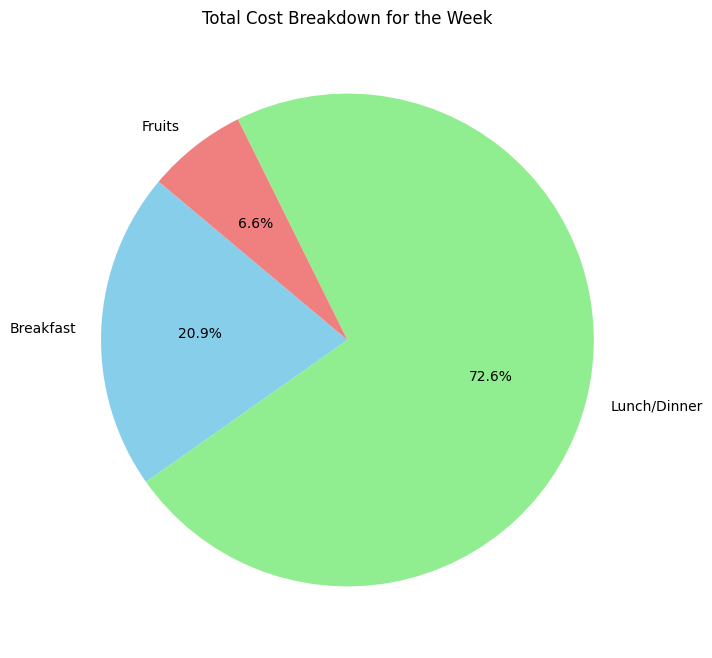

In [31]:
# Calculate total cost per category (Breakfast, Lunch/Dinner, Fruits)
breakfast_cost = sum(model.x1[day, breakfast_idx].value * breakfast_nutrition_and_cost[breakfast_idx][4]
                     for breakfast_idx in range(len(breakfast_meals)) for day in range(7))
lunch_dinner_cost = sum(model.x2[day, meal, meal_idx].value * meal_nutrition_and_cost[meal_idx][4]
                        for day in range(7) for meal in range(3) for meal_idx in range(len(lunch_and_dinner_meals)))
fruit_cost = sum(model.y[day, fruit_idx].value * fruit_nutrition_and_cost[fruit_idx][4]
                 for day in range(7) for fruit_idx in range(len(fruits)))

# Pie chart for cost breakdown
labels = ['Breakfast', 'Lunch/Dinner', 'Fruits']
sizes = [breakfast_cost, lunch_dinner_cost, fruit_cost]
colors = ['skyblue', 'lightgreen', 'lightcoral']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax.set_title("Total Cost Breakdown for the Week")
plt.show()


In [33]:
import pandas as pd
# Collect the optimized meal plan into a dictionary for table
meal_plan = {
    'Day': [f'Day {i+1}' for i in range(7)],
    'Breakfast': [breakfast_meals[breakfast_idx] for day in range(7) for breakfast_idx in range(len(breakfast_meals))
                  if model.x1[day, breakfast_idx].value == 1],
    'Lunch': [lunch_and_dinner_meals[meal_idx] for day in range(7) for meal in range(3)
              for meal_idx in range(len(lunch_and_dinner_meals)) if model.x2[day, meal, meal_idx].value == 1][::2],
    'Dinner': [lunch_and_dinner_meals[meal_idx] for day in range(7) for meal in range(3)
               for meal_idx in range(len(lunch_and_dinner_meals)) if model.x2[day, meal, meal_idx].value == 1][1::2],
    'Fruit': [fruits[fruit_idx] for day in range(7) for fruit_idx in range(len(fruits))
              if model.y[day, fruit_idx].value == 1]
}

df_meal_plan = pd.DataFrame(meal_plan)
df_meal_plan.set_index('Day', inplace=True)

# Display the meal plan table
print(df_meal_plan)


                                 Breakfast                  Lunch  \
Day                                                                 
Day 1                       Eggs and toast        Black Bean Bowl   
Day 2                             Pancakes              Spaghetti   
Day 3                  Yogurt with granola                  Pizza   
Day 4               Avocado toast with egg           Quinoa Salad   
Day 5                    Granola with milk        Veggie Stir Fry   
Day 6  Smoothie (Banana, Spinach, Protein)  Cauliflower Rice Bowl   
Day 7                   Oatmeal with fruit           Chicken Bowl   

                      Dinner       Fruit  
Day                                       
Day 1           Quinoa Salad  Strawberry  
Day 2                   Soup      Orange  
Day 3              Taco Bowl      Banana  
Day 4          Veggie Burger       Apple  
Day 5  Grilled Chicken Salad      Orange  
Day 6           Quinoa Salad      Banana  
Day 7         Grilled Salmon      